In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

In [2]:
us18_matches = pd.read_csv('tennis_data/2018-usopen-matches.csv')
us18_matches = us18_matches.dropna(axis=1, how='all')

us18_points = pd.read_csv('tennis_data/2018-usopen-points.csv')
us18_points = us18_points.dropna(axis=1, how='all')

matchups100 = pd.read_csv('matchups_atp100.csv')

In [8]:
matchups100.head()

,Unnamed: 0,Rafael Nadal,John Isner,Donald Young,Dudi Sela,Tomas Berdych,Fabio Fognini,Lukas Lacko,Mikhail Youzhny,Milos Raonic,...,Andrey Rublev,Karen Khachanov,Daniil Medvedev,Marius Copil,Nicolas Kicker,Tennys Sandgren,Denis Shapovalov,Marton Fucsovics,Stefanos Tsitsipas,Victor Estrella
0,Rafael Nadal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,John Isner,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Donald Young,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dudi Sela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tomas Berdych,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Get all player names from a tourney

def get_player_names(matches):
    return np.unique(np.append(matches.player1.values, matches.player2.values))

# Given a player name and tourney, get their matches
def get_player_points(player, matches, points):
    # Get all match numbers
    match_ids = matches[(matches['player1'] == player) | (matches['player2'] == player)].match_id

    player_points = points[points.match_id.isin(match_ids)]

    return player_points


def get_summary_stats(player, matches, match):
    match_metadata = matches[matches.match_id == match.loc[1].match_id]
    # Get Ace percentage for that match
    if match_metadata.player1[0] == player:
        return match.P1Ace
    else:
        return match.P2Ace

def get_serves(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_serves = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.ServeIndicator == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_serves = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.ServeIndicator == 2)]

    player_serves = p1_serves.append(p2_serves)
    #player_serves.reset_index()

    return player_serves

# Function for getting points that were not made by double faulting (the ball was put into play)
def get_plays(player, matches, player_points):
    plays = player_points[(player_points.P1DoubleFault == 0) & (player_points.P2DoubleFault == 0)]
    return plays

def get_net_points(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_nets = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.P1NetPoint == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_nets = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.P2NetPoint == 1)]

    player_nets = p1_nets.append(p2_nets)

    return player_nets

def get_distances(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_dists = player_points[(player_points.match_id.isin(p1_matches))].P1DistanceRun 

    p2_matches = matches[matches['player2'] == player].match_id
    p2_dists = player_points[(player_points.match_id.isin(p2_matches))].P2DistanceRun

    return (np.sum(p1_dists) + np.sum(p2_dists))

def get_unforced_errors(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_unf_err = player_points[(player_points.match_id.isin(p1_matches))].P1UnfErr

    p2_matches = matches[matches['player2'] == player].match_id
    p2_unf_err = player_points[(player_points.match_id.isin(p2_matches))].P2UnfErr

    return (np.sum(p1_unf_err) + np.sum(p2_unf_err))


# Given a list of players, we want to go through the entire dataset and calculate a running average of their stats
Some assumptions made by this model are that players do not significantly change their playstlye throughout this calcualtion period 2011-2020.

In [21]:
tour_players = list(set(np.append(us18_matches.player1.values, us18_matches.player2.values)))
players = matchups100.columns[1:]

# [x for x in tour_players if x in players]

In [29]:
players = matchups100.columns[1:]

colnames = ['nServes', 'Ace_Avg', 'SSpeed', 'nPlays', 'nNets', 'Net_Avg', 'Net_Win', 'Unf_Err']
player_stats = pd.DataFrame(0, index=players, columns=colnames)
player_stats.head()

#nadal_points = get_player_points('Rafael Nadal', us18_matches, us18_points)

tours = ['ausopen', 'frenchopen', 'usopen', 'wimbledon']


# Triply four loop dont tell my CS profs ;(
for year in np.arange(2011, 2018):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')

        tour_players = list(set(np.append(matches.player1.values, matches.player2.values)))

        # Go through tournament players only in the top 100 (avoids NaN values)
        for player in [x for x in tour_players if x in players]:
            player_points = get_player_points(player, matches, points)

            #if player not in player_stats.index:
            #    player_stats.loc[player] = np.zeros(len(colnames))
            
            update_row = []

            #-----------------------------------------------------------
            # Serve Stats
            #-----------------------------------------------------------
                # Calculate running average of Aces
            player_serves = get_serves(player, matches, points)

            ace_avg = (np.sum(player_serves.P1Ace) + np.sum(player_serves.P2Ace) + player_stats.loc[player].nServes * player_stats.loc[player].Ace_Avg) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)
                
            update_row.append(np.shape(player_serves)[0] + player_stats.loc[player].nServes)
            update_row.append(ace_avg)

                # Calculate running average serve speed
            serve_speed_avg = (np.sum(player_serves.Speed_MPH) + player_stats.loc[player].nServes * player_stats.loc[player].SSpeed) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)

            update_row.append(serve_speed_avg)

            #-----------------------------------------------------------
            # Net Stats
            #-----------------------------------------------------------
            player_plays = get_plays(player, matches, points)
            player_nets = get_net_points(player, matches, points)
                # Calculate running average of times player played the net
            avg_net_plays = (np.sum(player_nets.P1NetPoint) + np.sum(player_nets.P2NetPoint) + player_stats.loc[player].nPlays * player_stats.loc[player].Net_Avg) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            avg_net_wins = (np.sum(player_nets.P1NetPointWon) + np.sum(player_nets.P2NetPointWon) + player_stats.loc[player].nNets * player_stats.loc[player].Net_Win) \
                / (np.shape(player_nets)[0] + player_stats.loc[player].nNets)


            update_row.append(np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            update_row.append(np.shape(player_nets)[0] + player_stats.loc[player].nNets)
            update_row.append(avg_net_plays)
            update_row.append(avg_net_wins)

            #-----------------------------------------------------------
            # Gameplay Stats
            #-----------------------------------------------------------
                # Avg Rally length
            # avg_rally = (np.sum(player_plays.RallyCount) + player_stats.loc[player].nPlays * player_stats.loc[player].Rally_Ct) \
                # / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            # update_row.append(avg_rally)

                # Unforced error rate (consistency measure)
            player_errors = get_unforced_errors(player, matches, player_plays)
            avg_err = (player_errors + player_stats.loc[player].nPlays * player_stats.loc[player].Unf_Err) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            
            update_row.append(avg_err)


            player_stats.loc[player] = update_row


                # Avg distance ran during a point
            # player_dists = get_distances(player, matches, player_plays)
            # avg_dist = (player_dists + player_stats.loc[player].nPlays * player_stats.loc[player].Dists) \
                # / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            # update_row.append(avg_dist)


In [30]:
#player_stats = player_stats.dropna()
player_stats

,nServes,Ace_Avg,SSpeed,nPlays,nNets,Net_Avg,Net_Win,Unf_Err
Rafael Nadal,11332.0,0.051535,100.886693,797522.0,1765.0,0.002320,0.816431,0.003085
John Isner,8654.0,0.180263,105.664433,860404.0,2371.0,0.002807,0.653311,0.002927
Donald Young,3964.0,0.043643,67.471998,740325.0,993.0,0.001356,0.643505,0.001559
Dudi Sela,2468.0,0.040519,57.395057,537798.0,469.0,0.000893,0.692964,0.001142
Tomas Berdych,10922.0,0.096960,102.878136,888195.0,2406.0,0.002725,0.706983,0.003183
...,...,...,...,...,...,...,...,...
Tennys Sandgren,203.0,0.044335,65.645320,70179.0,25.0,0.000356,0.560000,0.000784
Denis Shapovalov,406.0,0.071429,72.763547,72751.0,106.0,0.001457,0.679245,0.001581
Marton Fucsovics,99.0,0.121212,96.222222,44020.0,13.0,0.000295,0.692308,0.000273
Stefanos Tsitsipas,205.0,0.097561,45.887805,85468.0,41.0,0.000480,0.658537,0.000480


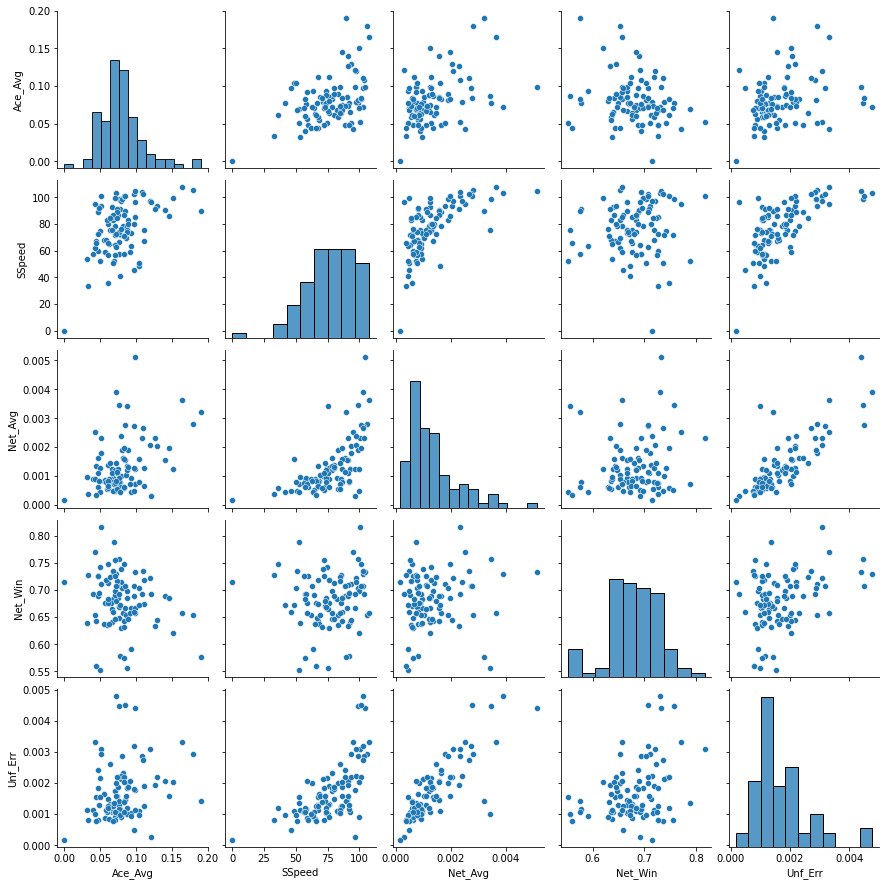

In [31]:
predictors = ['Ace_Avg', 'SSpeed', 'Net_Avg', 'Net_Win', 'Unf_Err']

player_stats_preds = player_stats[predictors]

sns.pairplot(player_stats_preds)

# Clustering

In [32]:
scaler = StandardScaler()
player_stats_scaled = scaler.fit_transform(player_stats_preds)

inertias = []

K = range(1,20)

for k in K:
    km = KMeans(
        init='random',
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=98
    )

    km = km.fit(player_stats_scaled)
    inertias.append(km.inertia_)

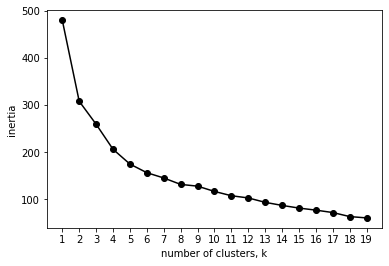

In [33]:
plt.plot(K, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(K)
plt.show()

Well that elbow plot isn't very encouragin, lets try some PCA?

- Look into Silhouette value for evaluating kmeans clustering

# Trying PCA

In [34]:
pca = decomposition.PCA()

pca.fit(player_stats_scaled)
PCA_components = pca.transform(player_stats_scaled)

In [35]:
pca.explained_variance_ratio_

array([0.53666245, 0.25265045, 0.10441579, 0.07766181, 0.02860951])

Text(0, 0.5, 'PCA 2')

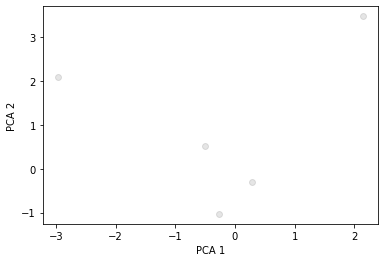

In [36]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

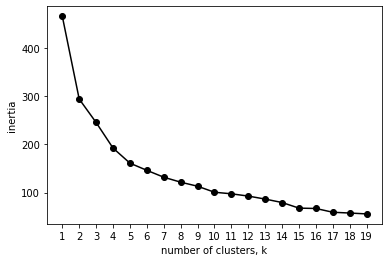

In [37]:
inertias = []

K = range(1,20)

for k in K:
    km = KMeans(
        init='random',
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=98
    )

    km = km.fit(PCA_components[:,:4])
    inertias.append(km.inertia_)


plt.plot(K, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(K)
plt.show()